In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Config

#path to file generated by other script will take more than one data set
DATA_FILES = [r"./data/synthetic_data_independent_failures_5.csv", "./data/synthetic_data_independent_failures_4.csv"]

SEQUENCE_LENGTH = 24 * 7
STEP_SIZE = 24 * 2
FORECAST_HORIZON = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Set device for training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Data processing 
def load_and_combine_data(file_paths):
    """
    Loads multiple CSV files, finds the union of all sensor features, 
    reindexes dataframes to match the full feature set (filling missing sensors with 0.0), 
    and concatenates them into a single DataFrame.
    """
    all_data = []
    all_sensor_features = set()
    
    # Load data and collect all unique sensor feature names
    non_sensor_cols = ['machine_id', "timestamp",'failure_mode', 'is_precursor_period', 'is_final_failure']
    
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            
            # Identify potential sensor features in the current file
            current_sensor_features = [col for col in df.columns if col not in non_sensor_cols]
            print(current_sensor_features)
            all_sensor_features.update(current_sensor_features)
            
            all_data.append(df)
            print(f"Loaded {file_path} with {len(current_sensor_features)} sensor features.")
        except FileNotFoundError:
            print(f"Warning: File '{file_path}' not found. Skipping.")
    
    if not all_data:
        raise FileNotFoundError("No valid data files were loaded.")

    
    sensor_feature_list = sorted(list(all_sensor_features))
    final_combined_df = pd.DataFrame()
    full_column_list = non_sensor_cols + sensor_feature_list
    
    for df in all_data:
        
        df_reindexed = df.reindex(columns=full_column_list, fill_value=0.0)
        
        final_combined_df = pd.concat([final_combined_df, df_reindexed], ignore_index=True)

    print(f"\nSuccessfully combined {len(all_data)} files.")
    print(f"Total rows in combined data: {len(final_combined_df)}")
    print(f"Total unique sensor features used: {len(sensor_feature_list)}")
    
    return final_combined_df, sensor_feature_list

In [3]:
try:
    data, sensor_features = load_and_combine_data(DATA_FILES)
except FileNotFoundError as e:
    print(f"Fatal Error: {e}")

['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_5.csv with 2 sensor features.
['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_4.csv with 2 sensor features.

Successfully combined 2 files.
Total rows in combined data: 236520
Total unique sensor features used: 2


In [4]:
def create_sequences(data, seq_length, forecast_horizon, step_size):
    sequences = []
    target = []
    for i in range(0, len(data) - seq_length - forecast_horizon + 1, step_size):
        sequences.append(data[i:i+seq_length])
        target.append(data[i+seq_length: i+seq_length+forecast_horizon])
    return np.array(sequences), np.array(target)

In [5]:
def prepare_data(df, sensor_features):
    """Loads, cleans, labels, and scales the data. Returns sequences and the fitted scaler."""
    sensor_data = df[sensor_features].values
   
    # 2. Standardization
    scaler = StandardScaler()
    sensor_data_scaled = scaler.fit_transform(sensor_data)
    
    # 3. Create Sequences
    X_seq, Y_seq = create_sequences(sensor_data_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON, STEP_SIZE)
    
    print(f"\n--- Data Preparation Complete ---")
    print(f"Total time points in raw data: {len(df)}")
    print(f"Total sequences created: {len(X_seq)}")
    print(f"Sequence shape (num_samples, time steps, features): {X_seq.shape}")
    
    # Return the fitted scaler so we can inverse-transform predictions later
    return X_seq, Y_seq, scaler

In [6]:
X_seq, Y_seq, scaler = prepare_data(data, sensor_features)

# Split data into training, validation, and testing sets for 3D arrays
# First split: 80% train+val, 20% test
indices = np.arange(X_seq.shape[0])
train_val_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=False)

# Second split: 75% train, 25% val (of the train+val set = 60% train, 20% val overall)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.25, random_state=42, shuffle=False)

X_train, X_val, X_test = X_seq[train_indices], X_seq[val_indices], X_seq[test_indices]
Y_train, Y_val, Y_test = Y_seq[train_indices], Y_seq[val_indices], Y_seq[test_indices]

print(f"\n--- Data Split ---")
print(f"Training set: {len(X_train)} sequences ({len(X_train)/len(X_seq)*100:.1f}%)")
print(f"Validation set: {len(X_val)} sequences ({len(X_val)/len(X_seq)*100:.1f}%)")
print(f"Test set: {len(X_test)} sequences ({len(X_test)/len(X_seq)*100:.1f}%)")

# ========== OPTIONAL: Filter Test Set by Months and Years ==========
# Configure month/year filtering for test set only (train/val use all data)
# Set to None to use all test data, or specify filters
# Examples: 
#   Months: (1, 6) for Jan-Jun, (7, 12) for Jul-Dec, (11, 2) for Nov-Feb
#   Years: (2025, 2025) for 2025 only, (2024, 2025) for 2024-2025

TEST_MONTH_FILTER = None  # (start_month, end_month) or None
TEST_YEAR_FILTER = None   # (start_year, end_year) or None

if TEST_MONTH_FILTER is not None or TEST_YEAR_FILTER is not None:
    # Convert timestamp to datetime for filtering
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Map test indices back to original data rows
    # Each sequence starts at: sequence_idx * STEP_SIZE
    test_start_indices = test_indices * STEP_SIZE
    
    # Get timestamps for each test sequence
    valid_test_mask = []
    
    for seq_idx, start_idx in zip(test_indices, test_start_indices):
        if start_idx < len(data):
            timestamp = data.iloc[start_idx]['timestamp']
            month = timestamp.month
            year = timestamp.year
            
            is_valid = True
            
            # Check month filter
            if TEST_MONTH_FILTER is not None:
                start_month, end_month = TEST_MONTH_FILTER
                if start_month <= end_month:
                    is_valid = is_valid and (start_month <= month <= end_month)
                else:  # Wrap-around case (e.g., Nov-Feb)
                    is_valid = is_valid and (month >= start_month or month <= end_month)
            
            # Check year filter
            if TEST_YEAR_FILTER is not None:
                start_year, end_year = TEST_YEAR_FILTER
                is_valid = is_valid and (start_year <= year <= end_year)
            
            valid_test_mask.append(is_valid)
        else:
            valid_test_mask.append(False)
    
    # Filter test data
    valid_test_mask = np.array(valid_test_mask)
    original_test_count = len(valid_test_mask)
    X_test = X_test[valid_test_mask]
    Y_test = Y_test[valid_test_mask]
    test_indices = test_indices[valid_test_mask]
    
    # Build filter description
    filter_desc = []
    if TEST_MONTH_FILTER is not None:
        filter_desc.append(f"Months {TEST_MONTH_FILTER[0]}-{TEST_MONTH_FILTER[1]}")
    if TEST_YEAR_FILTER is not None:
        filter_desc.append(f"Years {TEST_YEAR_FILTER[0]}-{TEST_YEAR_FILTER[1]}")
    
    print(f"\n--- Test Set Filtering ({', '.join(filter_desc)}) ---")
    print(f"Original test sequences: {original_test_count}")
    print(f"Filtered test sequences: {len(X_test)} ({len(X_test)/original_test_count*100:.1f}%)")
    if len(X_test) > 0:
        # Show date range of filtered test data
        test_dates = [data.iloc[idx * STEP_SIZE]['timestamp'] for idx in test_indices if idx * STEP_SIZE < len(data)]
        if test_dates:
            print(f"Test date range: {min(test_dates)} to {max(test_dates)}")
else:
    print("\nNo month/year filtering applied to test set")



--- Data Preparation Complete ---
Total time points in raw data: 236520
Total sequences created: 4924
Sequence shape (num_samples, time steps, features): (4924, 168, 2)



--- Data Split ---
Training set: 2954 sequences (60.0%)
Validation set: 985 sequences (20.0%)
Test set: 985 sequences (20.0%)

No month/year filtering applied to test set


In [7]:
# PYTORCH Model for fun or more like testing
class TimeDataset(Dataset):
    """Custom PyTorch Dataset for time-series sequences."""
    def __init__(self, X_data, y_data, feature_idx):
        self.X_data = torch.tensor(X_data[:, :, feature_idx: feature_idx + 1], dtype=torch.float32).permute(0, 2, 1)
        self.y_data = torch.tensor(y_data[:, :, feature_idx: feature_idx + 1], dtype=torch.float32).squeeze(-1)
        
    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [8]:
# # Imbalanced Data
# train_labels_series = pd.Series(Y_train)
# class_counts = train_labels_series.value_counts().sort_index()
# total_samples = len(Y_train)


# class_weights = total_samples / (NUM_CLASSES * class_counts)


# class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(DEVICE)

# print("\nCalculated Class Weights (Higher = More Important):")
# for i, weight in enumerate(class_weights_tensor):
#     print(f"Class {i} Weight: {weight:.2f}")

In [9]:
X_train.shape, Y_train.shape

((2954, 168, 2), (2954, 1, 2))

In [10]:
# Create PyTorch Datasets and DataLoaders
train_loader = []
val_loader = []
test_loader = []

for i in range(X_train.shape[2]):
    train_dataset = TimeDataset(X_train, Y_train, i)
    val_dataset = TimeDataset(X_val, Y_val, i)
    test_dataset = TimeDataset(X_test, Y_test, i)

    train_loader.append(DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True))
    val_loader.append(DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False))
    test_loader.append(DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False))


In [11]:
class CNNClassifier(nn.Module):
    """
    Simple 1D CNN for time-series regression built with PyTorch.
    Matches the Keras Conv1D + MaxPool + Dense architecture.
    """
    def __init__(self, seq_length, forecast_horizon):
        super(CNNClassifier, self).__init__()
        
        # Layer 1: Conv1D (64 filters, kernel size 3)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=0)
        
        # Layer 2: Max Pooling
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate flattened size after conv and pooling
        # seq_length -> (seq_length - 2) after conv -> (seq_length - 2) // 2 after pool
        conv_output_size = (seq_length - 2) // 2
        flattened_size = 64 * conv_output_size
        
        # Layer 3: Fully connected (Dense) layer with 100 units
        self.fc1 = nn.Linear(flattened_size, 100)
        
        # Layer 4: Output layer for regression
        self.fc2 = nn.Linear(100, forecast_horizon)

    def forward(self, x):
        # Conv + ReLU
        x = torch.relu(self.conv1(x))
        
        # Max Pooling
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense layer + ReLU
        x = torch.relu(self.fc1(x))
        
        # Output layer (no activation for regression)
        x = self.fc2(x)
        
        return x

In [12]:
# --- 3. TRAINING AND EVALUATION ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """PyTorch training loop with validation monitoring."""
    print(f"\n--- Starting PyTorch Model Training ({num_epochs} Epochs) ---")
    
    # Track losses for plotting
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
        
        # Calculate average training loss
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                val_batches += 1
        
        # Calculate average validation loss
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses


In [13]:
def evaluate_model(model, test_loader):
    """PyTorch evaluation loop for regression."""
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            
            # Forward pass - get predictions
            outputs = model(inputs)
            
            # Collect predictions and targets (no argmax for regression)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
            
    return np.array(y_true), np.array(y_pred)

def calculate_msre(y_pred, y_true):
    avg_error_per_column = np.mean(np.abs(y_true - y_pred), axis=0)
    print(f"Average error per column: {avg_error_per_column}")
    mse = np.mean((y_true - y_pred) ** 2)
    print(f"Total MSE: {mse}")
    return np.sqrt(mse)

In [14]:
select_model = 1

In [15]:
# Build the PyTorch CNN model
model = CNNClassifier(X_train.shape[1], FORECAST_HORIZON).to(DEVICE)

print("\nModel Architecture:")
print(model)


Model Architecture:
CNNClassifier(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5312, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


In [16]:
# Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model with validation
train_losses, val_losses = train_model(
    model, train_loader[select_model], val_loader[select_model], 
    criterion, optimizer, NUM_EPOCHS
)



--- Starting PyTorch Model Training (10 Epochs) ---
Epoch [1/10] - Train Loss: 1.1832, Val Loss: 0.8784
Epoch [2/10] - Train Loss: 0.8792, Val Loss: 0.7859
Epoch [3/10] - Train Loss: 0.8048, Val Loss: 0.8001
Epoch [4/10] - Train Loss: 0.8021, Val Loss: 0.7858
Epoch [5/10] - Train Loss: 0.7771, Val Loss: 0.7984
Epoch [6/10] - Train Loss: 0.7543, Val Loss: 0.8028
Epoch [7/10] - Train Loss: 0.7399, Val Loss: 0.7956
Epoch [8/10] - Train Loss: 0.7337, Val Loss: 0.7941
Epoch [9/10] - Train Loss: 0.7235, Val Loss: 0.8067
Epoch [10/10] - Train Loss: 0.7295, Val Loss: 0.8005


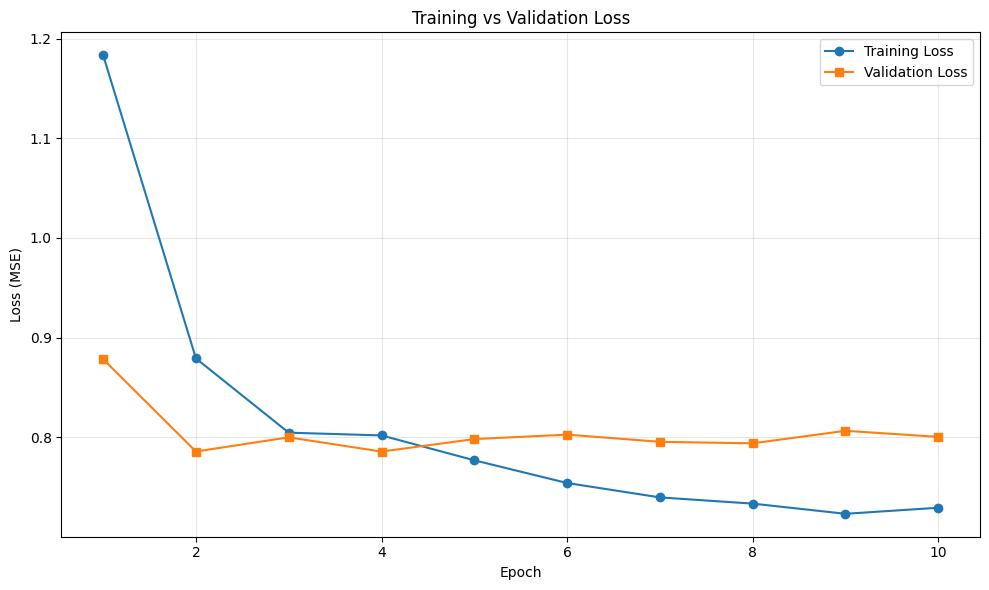


Final Training Loss: 0.7295
Final Validation Loss: 0.8005
Difference (Val - Train): 0.0710
Ratio (Val / Train): 1.10


In [17]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
loss_diff = final_val_loss - final_train_loss
loss_ratio = final_val_loss / final_train_loss

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Difference (Val - Train): {loss_diff:.4f}")
print(f"Ratio (Val / Train): {loss_ratio:.2f}")


In [18]:
# Evaluate the model
print("\n--- Evaluating Model Performance ---")
y_true, y_pred = evaluate_model(model, test_loader[select_model])

calculate_msre(y_pred, y_true)


--- Evaluating Model Performance ---
Average error per column: [0.76470506]
Total MSE: 1.193274736404419


np.float32(1.0923711)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Regression metrics
mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_true.flatten(), y_pred.flatten())

print("\nRegression Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Regression Metrics:
Mean Squared Error (MSE): 1.1933
Root Mean Squared Error (RMSE): 1.0924
Mean Absolute Error (MAE): 0.7647
R² Score: 0.1062


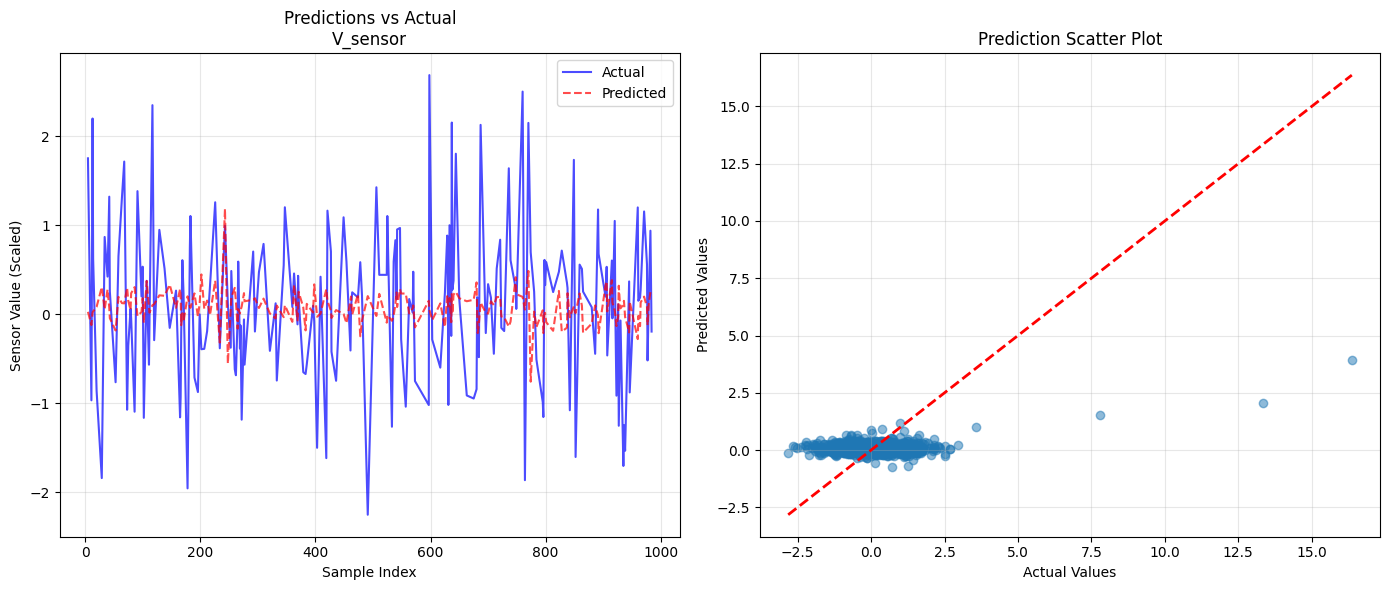

In [23]:
y_true_flat = np.array(y_true).reshape(-1)
y_pred_flat = np.array(y_pred).reshape(-1)

plt.figure(figsize=(14, 6))

# Sample a subset for visualization if too many points
num_samples = min(200, len(y_true_flat))
if num_samples == 0:
    print("No test samples available to plot.")
else:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    plt.subplot(1, 2, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7)
    plt.plot(indices, y_pred_flat[indices], 'r--', label='Predicted', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title(f'Predictions vs Actual\n{sensor_features[select_model]}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.5)
    mn = min(y_true_flat.min(), y_pred_flat.min())
    mx = max(y_true_flat.max(), y_pred_flat.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction Scatter Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()